# Setup

In [47]:
%run setup.ipynb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


# Simple processing and run

### Encoding

In [48]:
X = heart_failure_df.drop(target_col_name, axis=1)
y = heart_failure_df[target_col_name]

encode_categorical_features(X)

X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.0,2
1,49,0,2,160,180,0,1,156,0,1.0,1
2,37,1,1,130,283,0,2,98,0,0.0,2
3,48,0,0,138,214,0,1,108,1,1.5,1
4,54,1,2,150,195,0,1,122,0,0.0,2


In [49]:
from sklearn.model_selection import train_test_split # Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Helper functions

In [50]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import lightgbm as lgb


def random_forest_classifier(X_train, y_train, X_test, y_test, n_estimators=100):
    # Train a random forest classifier
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    print(f'Training accuracy for RandomForest: {train_acc}')

    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    return cm, clf.feature_importances_


def lightgbm_classifier(X_train, y_train, X_test, y_test, n_estimators=100):
    # Train a LightGBM classifier
    clf = lgb.LGBMClassifier(n_estimators=n_estimators, objective='binary', metric='binary_logloss', verbose=-1)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    print(f'Training accuracy for LightGBM: {train_acc}')

    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return cm, clf.booster_.feature_importance(importance_type='gain')


def run_and_plot(X_train, y_train, X_test, y_test, n_estimators=100, classifier_name='random_forest'):
    classifiers = {
        'random_forest': random_forest_classifier,
        'lightgbm': lightgbm_classifier
    }
    cm, feature_importances = classifiers[classifier_name](X_train, y_train, X_test, y_test, n_estimators=n_estimators)
    print_feature_importances(feature_importances, feature_names=X_train.columns)
    plt.figure()
    plot_confusion_matrix(cm, normalize=True, title=f'{classifier_name} Confusion Matrix')
    plt.show()

### Random forest

Training accuracy for RandomForest: 1.0
Feature ranking:
1. feature ST_Slope (0.245497)
2. feature Oldpeak (0.122748)
3. feature MaxHR (0.106279)
4. feature Cholesterol (0.101786)
5. feature ChestPainType (0.097983)
6. feature Age (0.095612)
7. feature ExerciseAngina (0.081695)
8. feature RestingBP (0.070602)
9. feature Sex (0.030398)
10. feature RestingECG (0.026296)
11. feature FastingBS (0.021107)


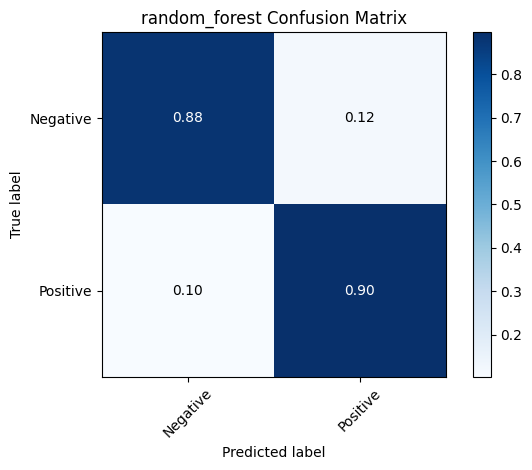

In [51]:
run_and_plot(X_train, y_train, X_test, y_test, n_estimators=200, classifier_name='random_forest')

### LightGBM

Training accuracy for LightGBM: 1.0
Feature ranking:
1. feature ST_Slope (1569.769219)
2. feature Oldpeak (618.256771)
3. feature MaxHR (464.613311)
4. feature Cholesterol (451.739179)
5. feature Age (396.068279)
6. feature ChestPainType (332.096914)
7. feature RestingBP (311.593737)
8. feature ExerciseAngina (209.947252)
9. feature Sex (149.538195)
10. feature FastingBS (67.996522)
11. feature RestingECG (66.286721)


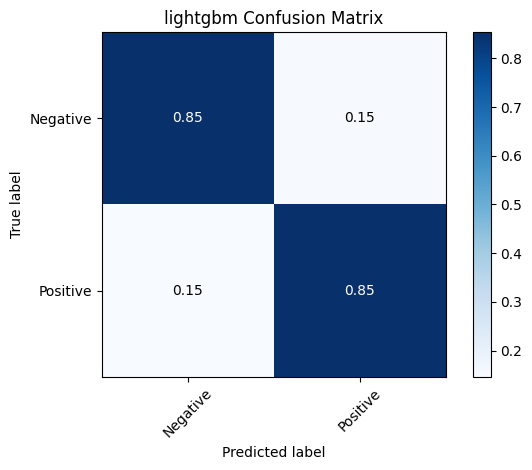

In [52]:
run_and_plot(X_train, y_train, X_test, y_test, n_estimators=200, classifier_name='lightgbm')

##### False Negative is still very high, considered for a medical classication problem, this is where we want to focus on improving.
##### Both _RandomForst_ and _LightGBM_ agree on the top 2 most important features, by order: _ST\_Slope_, _Oldpeak_.

### Checking if imbalance in target

In [53]:
print(y.value_counts())

HeartDisease
1    508
0    410
Name: count, dtype: int64


##### Around 25% higher for Positive
##### This shouldn't be a concern, we should focus more the features.

# Features engineering

### Age and MaxHR

count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64


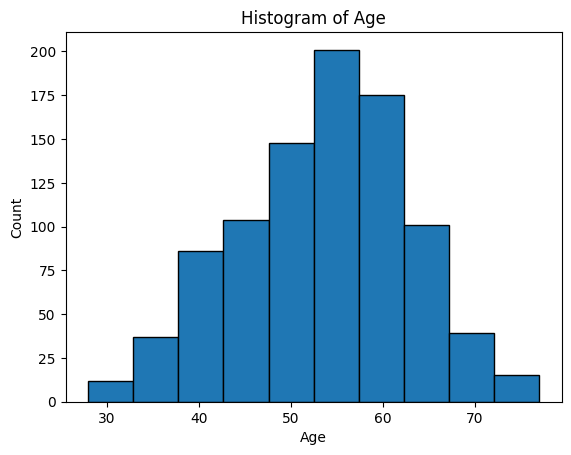

In [54]:
print(heart_failure_df['Age'].describe())

plt.hist(heart_failure_df['Age'], bins=10, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age')
plt.show()

##### Lets change this to three ranges: min to 44, 44 to 64, above 64 (this is from medical )

In [55]:
heart_failure_df_feature_engineered = heart_failure_df.copy()

heart_failure_df_feature_engineered['Age'] = pd.cut(heart_failure_df['Age'], bins=pd.IntervalIndex.from_tuples([(0, 44), (45, 64), (65, np.inf)]), 
                                                    labels=['0-44', '45-64', '65+'])
heart_failure_df_feature_engineered.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,"(0.0, 44.0]",M,ATA,140,289,False,Normal,172,N,0.0,Up,0
1,"(45.0, 64.0]",F,NAP,160,180,False,Normal,156,N,1.0,Flat,1
2,"(0.0, 44.0]",M,ATA,130,283,False,ST,98,N,0.0,Up,0
3,"(45.0, 64.0]",F,ASY,138,214,False,Normal,108,Y,1.5,Flat,1
4,"(45.0, 64.0]",M,NAP,150,195,False,Normal,122,N,0.0,Up,0


count    918.000000
mean     136.809368
std       25.460334
min       60.000000
25%      120.000000
50%      138.000000
75%      156.000000
max      202.000000
Name: MaxHR, dtype: float64


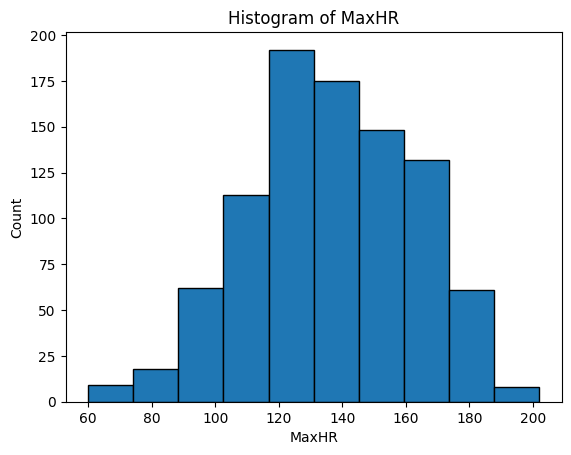

In [56]:
print(heart_failure_df['MaxHR'].describe())

plt.hist(heart_failure_df['MaxHR'], bins=10, edgecolor='black')
plt.xlabel('MaxHR')
plt.ylabel('Count')
plt.title('Histogram of MaxHR')
plt.show()

#### In Medical, normal max heart rate is derived from age

In [57]:
heart_failure_df_feature_engineered['max_hr_subtracted_by_age'] = heart_failure_df['MaxHR'] - heart_failure_df['Age']
heart_failure_df_feature_engineered.drop('MaxHR', axis=1, inplace=True)
heart_failure_df_feature_engineered.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,max_hr_subtracted_by_age
0,"(0.0, 44.0]",M,ATA,140,289,False,Normal,N,0.0,Up,0,132
1,"(45.0, 64.0]",F,NAP,160,180,False,Normal,N,1.0,Flat,1,107
2,"(0.0, 44.0]",M,ATA,130,283,False,ST,N,0.0,Up,0,61
3,"(45.0, 64.0]",F,ASY,138,214,False,Normal,Y,1.5,Flat,1,60
4,"(45.0, 64.0]",M,NAP,150,195,False,Normal,N,0.0,Up,0,68


In [58]:
X = heart_failure_df_feature_engineered.drop(target_col_name, axis=1)
encode_categorical_features(X)
y = heart_failure_df_feature_engineered[target_col_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Training accuracy for RandomForest: 1.0
Feature ranking:
1. feature ST_Slope (0.233666)
2. feature Oldpeak (0.126192)
3. feature max_hr_subtracted_by_age (0.124364)
4. feature Cholesterol (0.117138)
5. feature ChestPainType (0.107533)
6. feature ExerciseAngina (0.101330)
7. feature RestingBP (0.082268)
8. feature Sex (0.031034)
9. feature RestingECG (0.029376)
10. feature FastingBS (0.023652)
11. feature Age (0.023445)


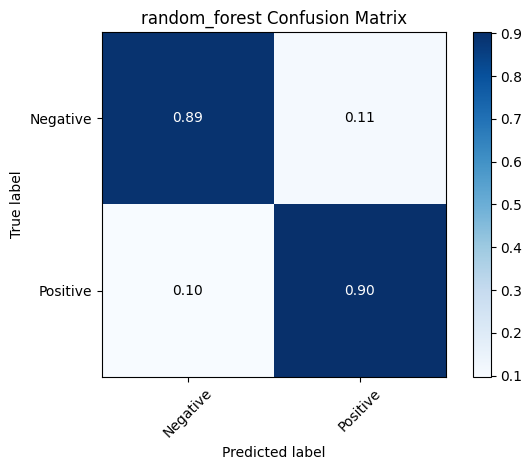

In [59]:
# try RandomForest again
run_and_plot(X_train, y_train, X_test, y_test, n_estimators=200, classifier_name='random_forest')

Training accuracy for LightGBM: 1.0
Feature ranking:
1. feature ST_Slope (1575.122229)
2. feature Oldpeak (654.515853)
3. feature max_hr_subtracted_by_age (605.190241)
4. feature Cholesterol (526.644695)
5. feature RestingBP (375.843138)
6. feature ChestPainType (333.304286)
7. feature ExerciseAngina (221.068944)
8. feature Sex (161.470829)
9. feature RestingECG (96.659026)
10. feature FastingBS (55.401779)
11. feature Age (29.994985)


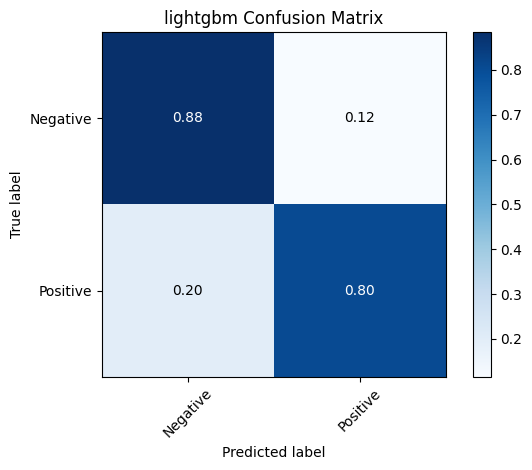

In [60]:
# try LightGBM again
run_and_plot(X_train, y_train, X_test, y_test, n_estimators=200, classifier_name='lightgbm')

##### We got much worse feature importance for Age, so this should be reverted.
##### max_hr_subtracted_by_age has a small gain in importance, so lets keep this.

In [61]:
heart_failure_df_feature_engineered['Age'] = heart_failure_df['Age']

### Other Categorical features

##### We notices that for some of this dataset's categorical features, there is big disparity in the popularity of categories, for example: Male is 79%, Normal FastingBS is ~ 75%, Normal RestingECG is 60%,...So lets try Frequency Encoding for these features.

In [62]:
heart_failure_df['Sex'].value_counts().max() / heart_failure_df['Sex'].count()

0.789760348583878

In [63]:
X = heart_failure_df_feature_engineered.drop(target_col_name, axis=1)
encode_categorical_features_as_frequency_encoding(X)
y = heart_failure_df_feature_engineered[target_col_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,ExerciseAngina,Oldpeak,ST_Slope,max_hr_subtracted_by_age
712,58,725,496,100,234,704,552,547,0.1,395,98
477,61,725,496,110,0,214,552,371,2.0,63,47
409,53,725,203,160,0,214,188,371,0.0,460,69
448,63,725,496,160,230,214,552,371,1.0,460,42
838,63,725,496,130,330,214,188,371,1.8,395,69


Training accuracy for RandomForest: 1.0
Feature ranking:
1. feature ST_Slope (0.210706)
2. feature Oldpeak (0.126499)
3. feature max_hr_subtracted_by_age (0.112034)
4. feature Cholesterol (0.109282)
5. feature ExerciseAngina (0.108878)
6. feature Age (0.096922)
7. feature ChestPainType (0.086002)
8. feature RestingBP (0.072845)
9. feature Sex (0.030790)
10. feature RestingECG (0.024130)
11. feature FastingBS (0.021912)


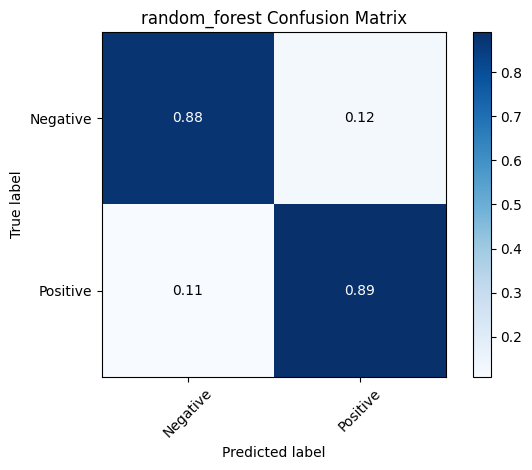

In [64]:
# try RandomForest again
run_and_plot(X_train, y_train, X_test, y_test, n_estimators=200, classifier_name='random_forest')

Training accuracy for LightGBM: 1.0
Feature ranking:
1. feature ST_Slope (1269.459029)
2. feature Oldpeak (756.401329)
3. feature Cholesterol (486.899431)
4. feature max_hr_subtracted_by_age (459.798214)
5. feature Age (383.620618)
6. feature ExerciseAngina (336.693924)
7. feature RestingBP (334.215700)
8. feature ChestPainType (326.705916)
9. feature Sex (149.296255)
10. feature RestingECG (72.966371)
11. feature FastingBS (67.117412)


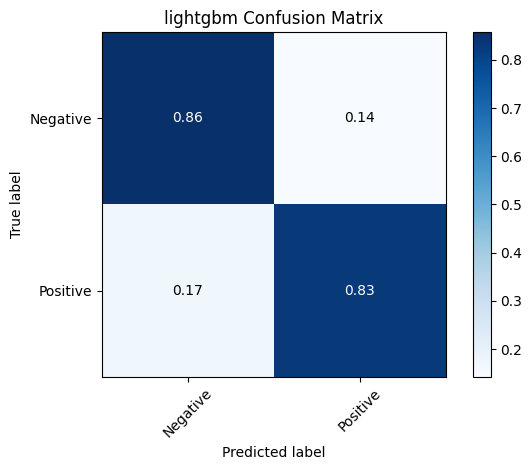

In [65]:
# try LightGBM again
run_and_plot(X_train, y_train, X_test, y_test, n_estimators=200, classifier_name='lightgbm')

##### Doesn't help much, so lets just stick to Label Encoding.

### Numerical Features

##### For tree-based models, scaling numeric features doesn't bring much improvement (These models use decision trees, which split data by making cuts at certain values of a feature. Whether a feature is scaled or not doesn’t change the way decisions are made in the trees).

##### Seems like features engineering and different encoding methods don't bring much improvent to False Negative rate, so lets go to Hyperparameters Tuning.

# Hyperparameter Tuning

### Helper functions

In [66]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def grid_search(X_train, y_train, classifier_name='random_forest'):
    classifiers = {
        'random_forest': RandomForestClassifier,
        'lightgbm': lgb.LGBMClassifier
    }
    param_grids = {
        'random_forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7], # Few features so we try small values to prevent overfitting
            'min_samples_split': [10, 20, 40], # Total samples is ~ 920
            'min_samples_leaf': [5, 10]
        },
        'lightgbm': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'num_leaves': [7, 15, 31],
            'learning_rate': [0.02, 0.05, 0.1]
        }
    }

    if classifier_name == 'lightgbm':
        classifier = classifiers[classifier_name](objective='binary', metric='binary_logloss', verbose=-1)
    else:
        classifier = classifiers[classifier_name]()
    param_grid = param_grids[classifier_name]

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=2)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    return grid_search

def print_best_params_plot_confusion_matrix(grid_search, X_test, y_test):
    print(f'Best parameters found: {grid_search.best_params_}')
    print(f'Best score found: {grid_search.best_score_}')

    y_pred = grid_search.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure()
    plot_confusion_matrix(cm, normalize=True, title='Confusion Matrix')
    plt.show()

In [67]:
# Prepare the data
X = heart_failure_df_feature_engineered.drop(target_col_name, axis=1)
encode_categorical_features(X)
y = heart_failure_df_feature_engineered[target_col_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best score found: 0.8629360465116278


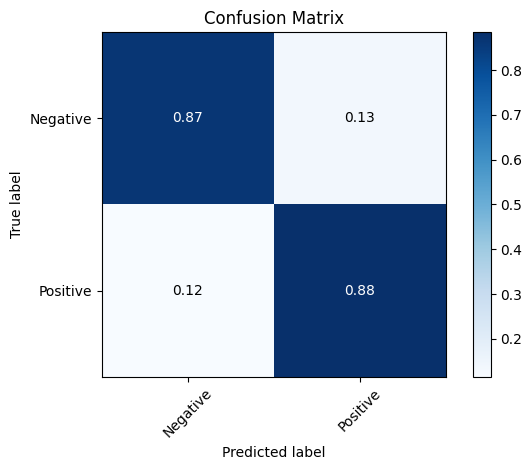

In [68]:
# Grid search for RandomForest
grid_search_rf = grid_search(X_train, y_train, classifier_name='random_forest')
print_best_params_plot_confusion_matrix(grid_search_rf, X_test, y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 15}
Best score found: 0.867611434108527


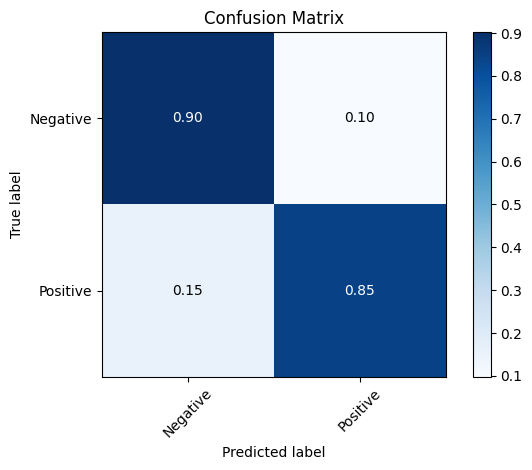

In [69]:
# Grid search for LightGBM
grid_search_lgb = grid_search(X_train, y_train, classifier_name='lightgbm')
print_best_params_plot_confusion_matrix(grid_search_lgb, X_test, y_test)